#### In this notebook, I am using Gridsearch on Voting Classifier

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier,\
VotingClassifier, RandomForestClassifier,ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report,\
plot_roc_curve

In [2]:
nut_die=pd.read_csv('../data/nutrition_vs_dietetics.csv')

In [3]:
nut_die.head()

,nd_subreddit,nd_title_text,nd_length,nd_word_count,nd_sentiment
0,1,Please help me figure out what’s wrong with my...,84,12,0.2942
1,1,What Tests For Iron Deficiency? Looking at get...,335,54,0.6544
2,1,How to get protein as a picky eater? [removed],46,9,0.0000
3,1,Suffering with canker sores [removed],37,5,-0.4767
4,1,Good diets/work outs? I am trying to lose weig...,204,39,0.2960


### Baseline 

In [4]:
nut_die['nd_subreddit'].value_counts(normalize=True)

0    0.502927
1    0.497073
Name: nd_subreddit, dtype: float64

### Set X and y variable

In [5]:
#separate the numerical features and text feature to use FeatureUnion later

get_text_data = FunctionTransformer(lambda x: x['nd_title_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['nd_length', 'nd_word_count']], validate = False)

In [6]:
nut_die['nd_title_text']=nut_die['nd_title_text'].str.replace('[^\w\s]', '')

X=nut_die[['nd_title_text','nd_length', 'nd_word_count']]
y=nut_die['nd_subreddit']

#after testing multiple times, when I replace all the puntuations when I set X, it improves
#the train score with estimator using TfidfVectorizer, 
#but decrease the train score with estimator using CountVectorizer
#Overall, doesn't make much difference

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=66,
                                               test_size=0.33,stratify=y)

## Voting Classifier with CountVectorizer

In [8]:
#customize the stopwords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['rd','ve','does','nutrition','removed','deleted','would','ive','dont',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

`add LemmaTokenizer into CountVectorizer`

In [9]:
#https://scikit-learn.org/stable/modules/feature_extraction.html
#https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [10]:
knn_pipe=Pipeline([('ss', StandardScaler(with_mean=False)),
                   ('knn',KNeighborsClassifier())])
vote=VotingClassifier([('LSVC',LinearSVC(max_iter=10000)),
                      ('SVC',SVC(max_iter=10000)),
                       ('Ada',AdaBoostClassifier()),
                      ('Gra',GradientBoostingClassifier()),
                      ('DecT',DecisionTreeClassifier()),
                      ('knn_pipe',knn_pipe),
                      ('RaF',RandomForestClassifier()),
                      ('XGB',XGBClassifier(use_label_encoder=False)),
                      ('ExT',ExtraTreesClassifier()),
                      ('Bag',BaggingClassifier()),
                      ('Log',LogisticRegression(max_iter=10000)),
                      ('MNB',MultinomialNB())])

In [11]:
pipe_c = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler(with_mean=False))
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(),
                                        stop_words=stopwords))
            ]))
    ])),('vc',vote)])

In [12]:
cross_val_score(pipe_c, X, y).mean()

[20:04:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

0.8936082073224096

In [13]:
#pipe.get_params()
#pipe.get_params().keys()

In [14]:
pipe_parames_c={'features__text_features__cvec__max_features':[3000,4000],
             'features__text_features__cvec__min_df':[2,3],
                'features__text_features__cvec__max_df':[.8,.85],
             'features__text_features__cvec__ngram_range':[(1,1),(1,2)]}

In [15]:
pipe_gridsearch_c=GridSearchCV(pipe_c,pipe_parames_c,cv=5)

In [16]:
pipe_gridsearch_c.fit(X_train,y_train);

[20:05:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:09:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:14:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [17]:
pipe_gridsearch_c.best_score_

0.8886833428330243

In [18]:
pipe_gridsearch_c.best_params_

{'features__text_features__cvec__max_df': 0.85,
 'features__text_features__cvec__max_features': 4000,
 'features__text_features__cvec__min_df': 3,
 'features__text_features__cvec__ngram_range': (1, 2)}

In [19]:
train_score_c=pipe_gridsearch_c.score(X_train,y_train)
train_score_c

0.9874620060790273

In [20]:
test_score_c=pipe_gridsearch_c.score(X_test,y_test)
test_score_c

0.8928296067848882

In [21]:
train_score_c-test_score_c  # really overfit

0.09463239929413914

In [22]:
y_pred_c=pipe_gridsearch_c.predict(X_test)
y_pred_c

array([1, 1, 1, ..., 0, 1, 1])

In [23]:
print(classification_report(y_test,y_pred_c))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       652
           1       0.86      0.94      0.90       645

    accuracy                           0.89      1297
   macro avg       0.90      0.89      0.89      1297
weighted avg       0.90      0.89      0.89      1297



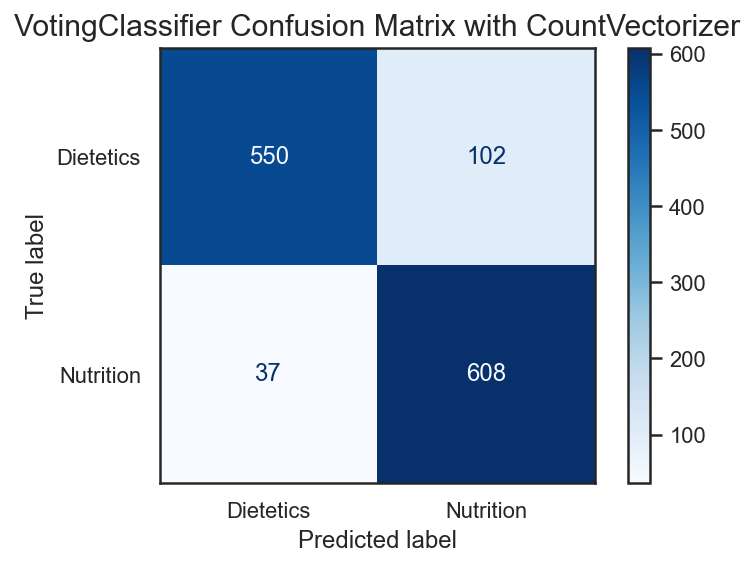

<Figure size 1440x720 with 0 Axes>

In [46]:
# Confusion Matrix for VotingClassifier

sns.set(font_scale=1)
sns.set_style('white')

plot_confusion_matrix(pipe_gridsearch_c, X_test, y_test, cmap='Blues', 
                      display_labels=['Dietetics', 'Nutrition'])

plt.title('VotingClassifier Confusion Matrix with CountVectorizer',size=15)

plt.figure(figsize=(20,10));

In [25]:
#plot_roc_curve(pipe_gridsearch_c,X_test,y_test);
# voting classifier only has roc when the voting method is soft/by probablity 

---

## Voting Classifier with TfidfVectorizer

In [28]:
#customize the stopwords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['rd','ve','does','nutrition','removed','deleted','would','ive','dont',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

`add LemmaTokenizer into TfidfVectorizer`

In [29]:
#https://scikit-learn.org/stable/modules/feature_extraction.html
#https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [30]:
knn_pipe=Pipeline([('ss', StandardScaler(with_mean=False)),
                   ('knn',KNeighborsClassifier())])
vote=VotingClassifier([('LSVC',LinearSVC(max_iter=10000)),
                      ('SVC',SVC()),
                       ('Ada',AdaBoostClassifier()),
                      ('Gra',GradientBoostingClassifier()),
                      ('DecT',DecisionTreeClassifier()),
                      ('knn_pipe',knn_pipe),
                      ('RaF',RandomForestClassifier()),
                      ('XGB',XGBClassifier(use_label_encoder=False)),
                      ('ExT',ExtraTreesClassifier()),
                      ('Bag',BaggingClassifier()),
                      ('Log',LogisticRegression()),
                      ('MNB',MultinomialNB())])

In [31]:
pipe_t = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler(with_mean=False))
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                        stop_words=stopwords))
            ]))
    ])),('vc',vote)])

In [32]:
cross_val_score(pipe_t, X, y).mean()

[20:22:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

0.8948814443850182

In [33]:
#pipe.get_params()
#pipe.get_params().keys()

In [34]:
pipe_parames_t={'features__text_features__tvec__max_features':[3000,4000],
             'features__text_features__tvec__min_df':[2,3],
                'features__text_features__tvec__max_df':[.8,.85],
             'features__text_features__tvec__ngram_range':[(1,1),(1,2)]}

In [35]:
pipe_gridsearch_t=GridSearchCV(pipe_t,pipe_parames_t,cv=5)

In [36]:
pipe_gridsearch_t.fit(X_train,y_train);

[20:23:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:27:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:31:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [37]:
pipe_gridsearch_t.best_score_

0.8913434968001674

In [38]:
pipe_gridsearch_t.best_params_

{'features__text_features__tvec__max_df': 0.8,
 'features__text_features__tvec__max_features': 4000,
 'features__text_features__tvec__min_df': 2,
 'features__text_features__tvec__ngram_range': (1, 2)}

In [39]:
train_score_t=pipe_gridsearch_t.score(X_train,y_train)
train_score_t

0.9821428571428571

In [40]:
test_score_t=pipe_gridsearch_t.score(X_test,y_test)
test_score_t

0.9043947571318427

In [41]:
train_score_t-test_score_t #slightly less overfit compare to previous model

0.0777481000110144

`results from CountVectorizer and TfidfVectorizer are really simillar`

In [42]:
y_pred_t=pipe_gridsearch_t.predict(X_test)
y_pred_t

array([1, 1, 1, ..., 0, 1, 1])

In [43]:
print(classification_report(y_test,y_pred_t))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       652
           1       0.87      0.95      0.91       645

    accuracy                           0.90      1297
   macro avg       0.91      0.90      0.90      1297
weighted avg       0.91      0.90      0.90      1297



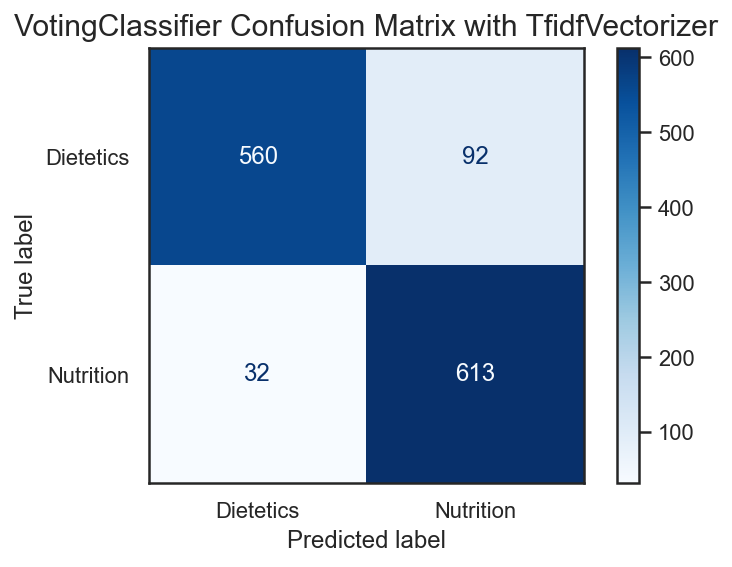

<Figure size 1440x720 with 0 Axes>

In [47]:
# Confusion Matrix for VotingClassifier

sns.set(font_scale=1)
sns.set_style('white')

plot_confusion_matrix(pipe_gridsearch_t, X_test, y_test, cmap='Blues', 
                      display_labels=['Dietetics', 'Nutrition'])

plt.title('VotingClassifier Confusion Matrix with TfidfVectorizer',size=15)

plt.figure(figsize=(20,10));

In [45]:
#plot_roc_curve(pipe_gridsearch_t,X_test,y_test);
# voting classifier only has roc when the voting method is soft/by probablity 